<h3>Libraries Needed</h3>

In [48]:
import requests
import itertools
from math import radians, cos, sin, asin, sqrt
from urllib3.util import Retry
from requests.adapters import HTTPAdapter
import polyline

from datetime import time, datetime, timedelta
import json
import math
import random
import ipyleaflet
from ipyleaflet import Map,AwesomeIcon,Marker,Polyline

import pettingzoo
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers

<h3>Global Definations Variables</h3>

In [49]:
# OSRM instance details
OSRM_HOST = "localhost"  # ROSRM server IP or hostname
OSRM_PORT = "5000"       # Port of OSRM server is listening on
SESSION = requests.Session()
RETRY = Retry(connect=5, read=5, backoff_factor=0.3)
ADAPTER = HTTPAdapter(max_retries=RETRY)
SESSION.mount('http://', ADAPTER)
SESSION.mount('https://', ADAPTER)

from datetime import timedelta

TIMEWINDOWORIGIN = 15*60 #15 MINUTES
TIMEWINDOWDEVIATION = 15*60 #15 MINUTES
SPEED = (60*1000)/3600 #M/S
REQUESTSTATES = {
    "NOT_CALLED": 0,
    "SCHEDULED": 1,
    "IN_PROGRESS": 2,
    "COMPLETED": 3,
    "REJECTED": 4
}

import copy
CAPACITY = 10
BUS_STOP_DATA_PATH = "./Data/bus_stops.json" #NEEDS TO BE RE-ARRANGED
MAP_BOUNDARIES = [35.793783, 14.289946,35.995368, 14.626382]
NUMBER_OF_DEPOTS = 5

REJECTED = 0
ACCEPTED = 1
ORIGIN_INDEX = 1
DESTINATION_INDEX = 2
MINIMUM_DISTANCE_OF_REQUEST = 0.1 #KM

<h2>Classes for DFBRP Simulator</h2>

<h3>Cords and Request_Cords</h3>

In [50]:
class Cords:
    def __init__(self, latidude, longitude):
        self.latidude = latidude
        self.longitude = longitude
    
    def __str__(self):
        return "lat: "+ str(self.latidude) + ",long: " + str(self.longitude)
    def __repr__(self):
        return "["+self.__str__()+"]"
    #Getters
    def getLatitude(self):
        return self.latidude
    def getLongitude(self):
        return self.longitude
    
    #Setters
    def setLatitude(self, latidude):
        self.latidude = latidude
    def setLongitude(self, longitude):
        self.longitude = longitude

class Request_Cords(Cords):
    def __init__(self, latidude, longitude, request_id, timeWindow, start):
        super().__init__(latidude, longitude)
        self.start = start
        self.request_id = request_id
        self.timeWindow = timeWindow
    
    def __str__(self):
        return "Req_Id: " + str(self.request_id) + ", lat: "+ str(self.latidude) + ", long: " + str(self.longitude) + ", " + str(self.start)
    def __repr__(self):
        return "["+self.__str__()+"]"
    def __eq__(self, requestCord):
        if self.request_id == requestCord.getRequestId() and self.start == requestCord.getStart():
            return True
        else:
            return False
    #Getters  
    def getLatitude(self):
        return self.latidude
    def getLongitude(self):
        return self.longitude   
    def getStart(self):
        return self.start
    def getRequestId(self):
        return self.request_id
    def getTimeWindow(self):
        return self.timeWindow

<h3>Vehicle and Vehicle_Stats</h3>

In [51]:
class Vehicle_Stats():
    def __init__(self):
        #Helper variables for statistics
        self.onGoingRequestList = {}
        self.completedRequestList = {}
        self.waitingReuqestList = {}

        #LIST OF STATISTICS
        self._totalDistance = 0 
        self._totalTime = 0 

        self._totalIdleTime = 0 #Done
        self._totalMovingTime = 0 

        self._totalRequests = 0 
        self._totalPassengers = 0 
        self._totalCompletedRequests = 0 

        self._currentDistance = 0 
        self._currentTime = 0
        self._requestWaitingTime = {}

        self._originPickUpTimes = {}
        self._destinationPickUpTimes = {}        

    def updateMovement(self,distance,time):
        if distance < 0 or time < 0:
            raise ValueError("Distance or Time cannot be negative")

        self._totalDistance += distance
        self._currentDistance += distance

        self._totalTime += time
        self._currentTime += time
        self._totalMovingTime += time

        self.addRequestWaitingTime(time)

    def acceptRequest(self,requestId,passengerAmount):
        if passengerAmount < 0:
            raise ValueError("Passenger Amount cannot be negative")
        self._totalRequests += 1
        self._totalPassengers += passengerAmount
        self._requestWaitingTime[requestId] = 0

    def completedRequest(self, requestId, completedTime):
        self._totalCompletedRequests += 1
        completedRequest = self.onGoingRequestList[requestId]
        del self.onGoingRequestList[requestId] #Remove the request from the onGoing list
        self.completedRequestList[requestId] = completedRequest #Add the request to the completed list
        self._destinationPickUpTimes[requestId] = completedTime
    
    def stayedIdle(self,time):
        if time < 0:
            raise ValueError("Time cannot be negative")
        self._totalIdleTime += time

    def resetCurrent(self):
        self._currentDistance = 0
        self._currentTime = 0

        self._requestWaitingTime = {}
        for key in self._requestWaitingTime:
            self._requestWaitingTime[key] = 0

    def addRequestWaitingTime(self,time):
        if time < 0:
            raise ValueError("Time cannot be negative")
        for key in self._requestWaitingTime:
            self._requestWaitingTime[key] += time

    def getRequestWaitingTime(self):
        time = 0
        for key in self._requestWaitingTime:
            time += self._requestWaitingTime[key]
        return time
    
    def getDistanceTravelled(self):
        return self._currentDistance

class Vehicle:
    def __init__(self, vehicleId,startingPosition, speed, capacity, cluster):
        if speed < 0 or capacity < 0:
            raise ValueError("Speed or Capacity cannot be negative")
        self.vehicleId = vehicleId
        self.position = copy.deepcopy(startingPosition)
        self.capacity = capacity
        self.currentLoad = 0
        self.speed = speed #IN METERS PER SECOND
        self.routeList = [] 
        self.route = []
        self.stats = Vehicle_Stats()
        self.timeNextArrival = None
        self.cluster = cluster

    def getRequestOSRMJSON(self, steps=False):
        if(steps == False):
            steps = "false"
        else:
            steps = "true"
        start_coords = str(self.position.getLongitude()) + "," + str(self.position.getLatitude())
        middle_coords = ""
        
        for cord in self.routeList:
            middle_coords += str(cord.getLongitude()) + "," + str(cord.getLatitude()) + ";"

        middle_coords = middle_coords[:-1]
        url = f"http://{OSRM_HOST}:{OSRM_PORT}/route/v1/driving/{start_coords};{middle_coords}?overview=full&steps={steps}"
        response = SESSION.get(url)
        #print(url)
        # Parsing the response
        if response.status_code == 200:
            data = response.json()
            return data
        else:
            Exception("Failed to get a response from the OSRM server")
    def _haversine(self,lat1, lon1, lat2, lon2):
        lon1 = radians(lon1)
        lon2 = radians(lon2)
        lat1 = radians(lat1)
        lat2 = radians(lat2)
        
        # Haversine formula 
        dlon = lon2 - lon1 
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    
        c = 2 * asin(sqrt(a)) 
        
        # Radius of earth in kilometers. Use 3956 for miles
        r = 6371
        
        # calculate the result
        return(c * r)
    def pointOnLine(self,lat1, lat2, lon1, lon2, percentage):
        #Get the point on the line at a specific percentage
        if percentage < 0 or percentage > 1:
            raise ValueError("Percentage must be between 0 and 1")
        lat = lat1 + percentage * (lat2 - lat1)
        lon = lon1 + percentage * (lon2 - lon1)
        return (lat,lon)

    def __str__(self):
        return "Position: " + str(self.position) + ", Capacity: " + str(self.capacity) + ", Current Load: " + str(self.currentLoad) + ", Route: " + str(self.routeList)
    def __repr__(self):
        return "["+self.__str__()+"]"

    #MOVEMENT FUNCTIONS
    def move(self,time,startTime):
        if time < 0:
            raise ValueError("Time cannot be negative")
        #Move for a specific amount of time in seconds
        #Calculate the total distance travelled in the time period
        self.stats.resetCurrent()
        timePassed = 0
        distance = self.speed * time
        if len(self.routeList) == 0:
            self.stats.stayedIdle(time)
            return
        
        osrmData = self.getRequestOSRMJSON()
        currentLeg = 0
        k = 0

        for leg in osrmData['routes'][0]['legs']:
            if leg['distance']+k < distance:
                k += leg['distance']
                timeToTravelDistance = leg['distance']/self.speed
                timePassed += timeToTravelDistance
                self.stats.updateMovement(leg['distance'],timeToTravelDistance)
                self.position.setLatitude(self.routeList[0].getLatitude())
                self.position.setLongitude(self.routeList[0].getLongitude())
                self.arrivedAtNextStop(startTime+timedelta(seconds=timePassed))
                self.timeNextArrival = None
                currentLeg += 1
            else:
                self._updateRoute()
                timeNextLeg = leg['distance']/self.speed
                break

        if len(self.routeList) == 0:
            idleTime = (distance-k)/self.speed
            self.stats.stayedIdle(idleTime)
            return
        
        distance -= k
        #EstimatePositons
        while distance > 0 and len(self.route) > 0:
            harvineDistance = 0
            if len(self.route) > 1:
                harvineDistance = self._haversine(self.route[0][0],self.route[0][1],self.route[1][0],self.route[1][1]) * 1000 #IN METERS
            else:
                #Final waypoint
                harvineDistance = self._haversine(self.position.getLatitude(),self.position.getLongitude(),self.route[0][0],self.route[0][1]) * 1000
                self.position.setLatitude(self.route[0][0])
                self.position.setLongitude(self.route[0][1])
            if harvineDistance <= distance:
                self.route.pop(0)
                distance -= harvineDistance
            else:
                #Calculate the new position of the vehicle
                #Get the harvine distance as a fraction of the distance
                percentage = distance/harvineDistance
                if len(self.route) > 1:
                    newLat,newLon = self.pointOnLine(self.route[0][0],self.route[1][0],self.route[0][1],self.route[1][1],percentage)
                    self.position.setLatitude(newLat)
                    self.position.setLongitude(newLon)
                break
        
        # if (suppostTravelled-totalDistanceTravelled) > 300:
        #     print("Distance Travelled: " + str(totalDistanceTravelled))
        #     print("Supposed Distance Travelled: " + str(suppostTravelled))
        #     print("Distance Diff: " + str(suppostTravelled-totalDistanceTravelled))

            # if len(self.routeList) == 0: #If Route Completed
            #     #Get the time idle from the distance remaining to travel
            #     time = distance/self.speed
            #     self.stats.stayedIdle(time)     
        # if len(self.route) == 0 and len(self.routeList) == 1:
        #     self.position.setLatitude(self.routeList[0].getLatitude())
        #     self.position.setLongitude(self.routeList[0].getLongitude())
        #     self.arrivedAtNextStop()
        #     self._updateRoute()
        #     currentLeg += 1
        #     distanceTravelled = 0
        #     supposedToBeCompleted -= 1
        # if supposedToBeCompleted > 0 and (osrmData['routes'][0]['legs'][currentLeg]['distance']-distanceTravelled) > 300:
        #     stringOfLegs = ""
        #     for i in range(len(osrmData['routes'][0]['legs'])):
        #         stringOfLegs += "\nLeg " + str(i) + " Distance: " + str(osrmData['routes'][0]['legs'][i]['distance'])
        #     stringOfConditions = ""
        #     stringOfConditions += "\n Conditions :\n Distance > 0: " + str(distance > 0) 
        #     stringOfConditions += "\n RouteList > 0: " + str(len(self.routeList) > 0)
        #     stringOfConditions += "\n Route > 0: " + str(len(self.route) > 0)
        #     raise ValueError("Vehicle did not complete the route: Distance Travelled: " + str(totalDistanceTravelled) + " Distance Remaining: " + str(osrmData['routes'][0]['legs'][currentLeg]['distance']-distanceTravelled) + "Original Distance"+ str(originalDistance)+ " All Legs:" + stringOfLegs + stringOfConditions)
    def arrivedAtNextStop(self,arrivalTime):
        #Get the next stop
        cords = self.routeList.pop(0)
        requestId = cords.getRequestId()
        
        if cords.getStart() == True:
            self.stats.waitingReuqestList[requestId].changeState("IN_PROGRESS") #Change the state
            self.stats.onGoingRequestList[requestId] = self.stats.waitingReuqestList[requestId] #Add the request to the onGoing list
            del self.stats.waitingReuqestList[requestId] #Remove the request from the waiting list
            self.stats._originPickUpTimes[requestId] = arrivalTime
        else:
            self.stats.onGoingRequestList[requestId].changeState("COMPLETED") #Change the state
            self.stats.completedRequestList[requestId] = self.stats.onGoingRequestList[requestId] #Add the request to the completed list
            self.currentLoad -= self.stats.onGoingRequestList[requestId].getPassengerAmount() #Update the amount of passengers in the vehicle
            self.stats.completedRequest(requestId,arrivalTime) #Update the statistics
    
    #ADDING REQUESTS FUNCTIONS
    def _updateRoute(self):
        #Update the route of the vehicle
        if len(self.routeList) == 0:
            self.route = []
            return
        data = self.getRequestOSRMJSON()
        self.route = polyline.decode(data['routes'][0]['geometry'])
    def addRequest(self,request,indexStart,indexEnd):
        #Add a request to the vehicle
        destination = request.getDestination()
        origin = request.getOrigin()

        if indexStart < 0 or indexEnd < 0:
            raise ValueError("Index cannot be negative")
        
        if indexStart > indexEnd:
            raise ValueError("Index Start cannot be greater than Index End")

        self.routeList.insert(indexStart,origin)
        self.routeList.insert(indexEnd,destination)
        self.currentLoad += request.getPassengerAmount()
        self._updateRoute()
        self.stats.acceptRequest(request.getId(),request.getPassengerAmount())
        self.stats.waitingReuqestList[request.getId()] = request

    #GETTERS
    def getId(self):
        return self.vehicleId
    def getPosition(self):
        return self.position   
    def getCapacity(self):
        return self.capacity
    def getCurrentLoad(self):
        return self.currentLoad   
    def getRoute(self):
        return self.route   
    def getStats(self):
        return self.stats
    def getRouteDistance(self):
        if len(self.routeList) == 0:
            return 0
        data = self.getRequestOSRMJSON()
        return data['routes'][0]['distance']
    def getRouteDuration(self):
        if len(self.routeList) == 0:
            return 0
        distance = self.getRouteDistance()
        return distance/self.speed
    def getRouteSize(self):
        return len(self.routeList)
    def getListOfCords(self):
        return self.routeList
    def getDistanceTravelled(self):
        return self.stats.getDistanceTravelled()
    def getRequestWaitingTime(self):
        return self.stats.getRequestWaitingTime()
    def getDeadHeadingDistance(self):
        if len(self.routeList) == 0:
            return 0
        #Assuming cords are pairs with start and end and pairs share the same request id
        #Find if there is a singular pair with end but not start
        listStart = []
        listEnd = []
        for cord in self.routeList:
            if cord.getStart() == True:
                listStart.append(cord)
            else:
                listEnd.append(cord)
        
        for cord in listEnd:
            if cord not in listStart:
                data = self.getRequestOSRMJSON()
                #Return distance of first leg
                return data['routes'][0]['legs'][0]['distance']
    def getCluster(self):
        return self.cluster

<h3>Request</h3>

In [52]:
class Request():
    def __init__(self, request_id, origin, destination, time, passengerAmount,cluster):
        self.request_id = request_id
        self.time = time
        oringinTimeWindow, destinationTimeWindow = self._getTimeWindows(origin,destination,time)
        self.origin = Request_Cords(origin.getLatitude(), origin.getLongitude(), self.request_id,oringinTimeWindow, True)
        self.destination = Request_Cords(destination.getLatitude(), destination.getLongitude(), self.request_id,destinationTimeWindow, False)
        self.state = REQUESTSTATES["NOT_CALLED"]
        self.passengerAmount = passengerAmount
        self.cluster = cluster

    def __str__(self):
        return "Request: id: {}, passengerAmount: {}, time: {}, origin: {}, destination: {},".format(self.request_id, self.passengerAmount, self.time, self.origin, self.destination)  
    def __repr__(self):
        return self.__str__()   

    #Calculating the timeWindow
    def _getTimeWindows(self, origin, destination, time):
        originTime = time + timedelta(seconds=TIMEWINDOWORIGIN)
        timeToTravel = self._getTimeBetweenPoints(origin, destination)
        if timeToTravel == None:
            print("Error in getting the time between points")
            print("Origin: "+str(origin))
            print("Destination: "+str(destination))
        destinationTime = time + timedelta(seconds=(timeToTravel)) + timedelta(seconds=(TIMEWINDOWORIGIN+TIMEWINDOWDEVIATION))
        return originTime, destinationTime    
    def _getTimeBetweenPoints(self, origin, destination):
        firstCord = str(origin.getLongitude()) + "," + str(origin.getLatitude())
        secondCord =  str(destination.getLongitude()) + "," + str(destination.getLatitude())
        url = f"http://{OSRM_HOST}:{OSRM_PORT}/route/v1/driving/{firstCord};{secondCord}?overview=full"

        response = SESSION.get(url)
        if response.status_code == 200:
            data = response.json()
            distance = data['routes'][0]['distance']  # Distance in meters
            # print("Distance between two points:" +str(distance)+", time to complete: "+str(distance/SPEED))
            return distance/SPEED
    def _getDistanceBetweenPoints(self):
        firstCord = str(self.origin.getLongitude()) + "," + str(self.origin.getLatitude())
        secondCord =  str(self.destination.getLongitude()) + "," + str(self.destination.getLatitude())
        url = f"http://{OSRM_HOST}:{OSRM_PORT}/route/v1/driving/{firstCord};{secondCord}?overview=full"

        response = SESSION.get(url)
        if response.status_code == 200:
            data = response.json()
            distance = data['routes'][0]['distance']  # Distance in meters
            # print("Distance between two points:" +str(distance)+", time to complete: "+str(distance/SPEED))
            return distance
    #Getters
    def getId(self):
        return self.request_id
    def getPassengerAmount(self):
        return self.passengerAmount
    def getOrigin(self):
        return self.origin
    def getDestination(self):
        return self.destination 
    def getTime(self):
        return self.time
    def getState(self):
        return self.state   
    def changeState(self, state):
        if state in REQUESTSTATES:
            self.state = REQUESTSTATES[state]
        else:
            raise ValueError("Invalid state")
    def getCluster(self):
        return self.cluster

<h3>Cluster Data</h3>

1715
1715


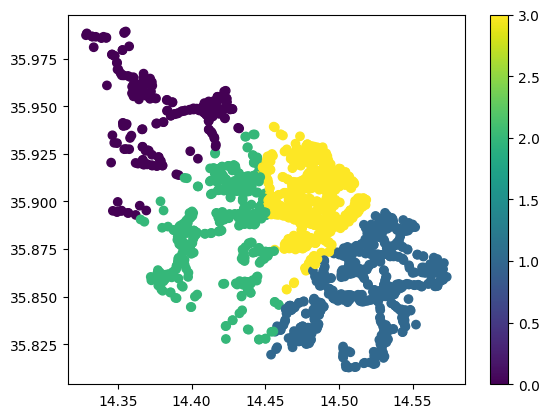

In [53]:
from sklearn.cluster import KMeans
import json
import matplotlib.pyplot as plt

f = open(BUS_STOP_DATA_PATH, "r",encoding="utf-8")
data = json.load(f)
elements = data["elements"]

longitudes = []
latitudes = []
for element in elements:
    longitudes.append(element["lon"])
    latitudes.append(element["lat"])

print(len(longitudes))
print(len(latitudes))

data = list(zip(longitudes, latitudes))
kmeans = KMeans(n_clusters=NUMBER_OF_DEPOTS)
kmeans.fit(data)

plot = plt.scatter(longitudes, latitudes, c=kmeans.labels_, label=kmeans.labels_)
plt.colorbar(plot) 
#Create a new json file with the cluster data
formattedDict = {}
for i in range(NUMBER_OF_DEPOTS):
    formattedDict[str(i)] = []

cluster_data = {
    "clusters": NUMBER_OF_DEPOTS, #Number of clusters
    "cluster_data": formattedDict
}

for i in range(len(longitudes)):
    cluster_data["cluster_data"][str(kmeans.labels_[i])].append({
        "lat": latitudes[i],
        "lon": longitudes[i]
    })

cluster_data["cluster_centers"] = {}
for i in range(len(kmeans.cluster_centers_)):
    cluster_data["cluster_centers"][i] = {
        "lat": kmeans.cluster_centers_[i][1],
        "lon": kmeans.cluster_centers_[i][0]
    }

with open('data/clustered.json', 'w+') as outfile:
    json.dump(cluster_data, outfile)

<h3>DFBRP Simulator</h3>

In [54]:
def divide_time_interval(n):
    # Define start and end times
    start_time = datetime.strptime("08:00 AM", "%I:%M %p")
    end_time = datetime.strptime("12:00 AM", "%I:%M %p")

    # Calculate total duration in seconds
    total_duration = (end_time - start_time).seconds

    # Calculate duration of each interval in seconds
    interval_duration = total_duration / n

    # Generate time intervals
    intervals = []
    start = time(8, 0)
    datetime_obj = datetime.combine(datetime.today(), start)
    for i in range(n):
        interval_start = datetime_obj + timedelta(seconds=i * interval_duration)
        intervals.append(interval_start)
    return intervals

class DFBRPSimulator():
    def __init__(self, vehicleAmount, numberOfRequests,render_mode=None):

        if vehicleAmount < 0 or numberOfRequests < 0:
            raise ValueError("Vehicle Amount or Number of Requests cannot be negative")

        self.clusterData = self._getClusterData()
        self.vehicles = self.initVehicles(vehicleAmount)
        self.requests = self.initRequests(numberOfRequests)
        self.currentRequest = self.requests[0]
        self.currentRequestIndex = 0
        self.rejectedRequests = []
        self.handledRequest = False
        self.render_mode = render_mode
        if render_mode == "human":
            f = open(BUS_STOP_DATA_PATH, "r",encoding="utf-8")
            data = json.load(f)
            elements = data["elements"]
            elementsLen = len(elements)
            smallestLat = math.inf
            smallestLon = math.inf
            largestLat = -math.inf
            largestLon = -math.inf
            for i in range(elementsLen):
                lat = elements[i]["lat"]
                lon = elements[i]["lon"]
                if lat < smallestLat:
                    smallestLat = lat
                if lon < smallestLon:
                    smallestLon = lon
                if lat > largestLat:
                    largestLat = lat
                if lon > largestLon:
                    largestLon = lon
            f.close()

            #Find the center of the map
            centerLat = (largestLat + smallestLat)/2
            centerLon = (largestLon + smallestLon)/2

            self.map = Map(center=[centerLat,centerLon], zoom=11)
            display(self.map)
            self.initMap()
    def __str__ (self):
        stringOutput = "==========================================\n Vehicles: \n"
        for vehile in self.vehicles:
            stringOutput += str(vehile) + "\n"
        stringOutput += "==========================================\n Requests: \n"
        for request in self.requests:
            stringOutput += str(request) + "\n"
        stringOutput += "==========================================\n"
        return stringOutput
    
    #Rendering Logic
    def initMap(self):
        self.colors = ["red","blue","green","purple","orange","darkred","white","black","darkblue","darkgreen"]
        self.layersDict = {}
        for i,vehicle in enumerate(self.vehicles):
            vehicleLocation = vehicle.getPosition()
            marker = Marker(location=(vehicleLocation.getLatitude(),vehicleLocation.getLongitude()),
                             icon=AwesomeIcon(name='bus', marker_color=self.colors[i%10], icon_color='white', spin=False),
                             draggable=False,
                             title="Bus "+str(i))
            self.map.add_layer(marker)
            self.layersDict["Bus "+str(i)] = marker
    def _resetPolyLines(self):
        for layer in self.map.layers:
            if isinstance(layer, ipyleaflet.Polyline):
                self.map.remove_layer(layer)
        for i,vehicle in enumerate(self.vehicles):
            if vehicle.getRouteSize() > 0:
                routeLine = Polyline(locations=vehicle.route, color=self.colors[i%10], weight=2, opacity=1, fill=False)
                self.map.add_layer(routeLine)
    def _resetBusesMarkers(self):
        for i,vehicle in enumerate(self.vehicles):
            vehicleLocation = vehicle.getPosition()
            if vehicleLocation.getLatitude() == self.layersDict["Bus "+str(i)].location[0] and vehicleLocation.getLongitude() == self.layersDict["Bus "+str(i)].location[1]:
                continue
            layer = self.layersDict["Bus "+str(i)]
            self.map.remove(layer)
            
            marker = Marker(location=(vehicleLocation.getLatitude(),vehicleLocation.getLongitude()),
                             icon=AwesomeIcon(name='bus', marker_color=self.colors[i%10], icon_color='white', spin=False),
                             draggable=False,
                             title="Bus "+str(i))
            self.map.add_layer(marker)
            self.layersDict["Bus "+str(i)] = marker
    def _addMarkers(self,vehicleIndex):
        request = self.currentRequest
        origin = request.getOrigin()
        destination = request.getDestination()
        markerOrigin = Marker(location=(origin.getLatitude(),origin.getLongitude()),
        icon=AwesomeIcon(name='map-marker', marker_color=self.colors[vehicleIndex%10], icon_color="white", spin=False),
        draggable=False)
        markerDestination = Marker(location=(destination.getLatitude(),destination.getLongitude()),
        icon=AwesomeIcon(name='map-marker', marker_color=self.colors[vehicleIndex%10], icon_color="white", spin=False),
        draggable=False)
        self.map.add_layer(markerOrigin)
        self.map.add_layer(markerDestination)
        self.layersDict["Request "+str(request.getId())+str(origin.getStart())] = markerOrigin
        self.layersDict["Request "+str(request.getId())+str(destination.getStart())] = markerDestination
    def _checkMarkers(self):
        currentMarkersLeft = set()
        for vehicle in self.vehicles:
            if vehicle.getRouteSize() > 0:
                for cord in vehicle.getListOfCords():
                    currentMarkersLeft.add("Request "+str(cord.getRequestId())+str(cord.getStart()))
        for key in list(self.layersDict.keys()):
            if key not in currentMarkersLeft and "Bus" not in key:
                self.map.remove(self.layersDict[key])
                del self.layersDict[key]
    def _updateMap(self):
        self._resetPolyLines()
        self._resetBusesMarkers()
        self._checkMarkers() 

    #GetClusterData
    def _getClusterData(self):
        self.clusterData = json.load(open("data/clustered.json"))
        self.clusterAmount = self.clusterData["clusters"]
        return self.clusterData

    #Initialization Logic
    def initVehicles(self, vehicleAmount):
        vehicles = []
        if vehicleAmount < self.clusterAmount:
            raise ValueError("Vehicle amount is less than the amount of clusters.")
        
        #Get the amount of bus stops in each cluster
        busStopsClusterCount = {}
        for cluster in self.clusterData["cluster_data"]:
            busStopsClusterCount[cluster] = len(self.clusterData["cluster_data"][cluster])
        
        self.totalBusStops = sum(busStopsClusterCount.values())
        clusterRatios = {cluster: items/self.totalBusStops for cluster, items in busStopsClusterCount.items()}

        #Distribute the bus stops to the vehicles
        distributedVehicles = {cluster: 1 for cluster in self.clusterData["cluster_data"]}
        remainingVehicles = vehicleAmount - self.clusterAmount
        reminder = []

        for cluster, proportion in clusterRatios.items():
            reminder.append((proportion *remainingVehicles) % 1)
            additionalVehicles = math.floor(proportion * remainingVehicles)
            distributedVehicles[cluster] += additionalVehicles
        remainingVehicles = vehicleAmount - sum(distributedVehicles.values())
        for _ in range(remainingVehicles):
            maxIndex = reminder.index(max(reminder))
            distributedVehicles[str(maxIndex)] += 1
            reminder[maxIndex] = 0

        #Check that the sum = numOfVehicles
        if sum(distributedVehicles.values()) != vehicleAmount:
            raise ValueError("The vehicles are not distributed correctly")
        
        #Get the center of the clusters
        clusterBusStops = copy.deepcopy(self.clusterData["cluster_centers"])
        clusterCenters = {}
        
        #For each cluster center find a busStop that is closest to it
        for cluster in clusterBusStops:
            clusterCenter = [clusterBusStops[cluster]["lat"], clusterBusStops[cluster]["lon"]]
            closestBusStop = None
            closestDistance = math.inf
            for busStop in self.clusterData["cluster_data"][cluster]:
                busStopCords = [busStop["lat"], busStop["lon"]]
                distance = math.dist(clusterCenter, busStopCords)
                if distance < closestDistance:
                    closestDistance = distance
                    closestBusStop = busStopCords
            clusterCenters[cluster] = closestBusStop
        
        #Create the vehicles and assign them to the clusters
        veh_id = 0
        for cluster, amount in distributedVehicles.items():
            for _ in range(amount):
                vehicles.append(Vehicle(veh_id, Cords(clusterCenters[cluster][0], clusterCenters[cluster][1]), SPEED, CAPACITY, int(cluster)))
                veh_id += 1
        
        return vehicles
    def initRequests(self, numberOfRequests):
        requestId = 0
        requestList = []
        timeIntervals = divide_time_interval(numberOfRequests)
        emptyVehicle = Vehicle(-1,Cords(0,0),SPEED,CAPACITY,0)
        for i in range(numberOfRequests):
            #Get two random indexes from all the bus stops 
            r1 = random.randint(0, self.totalBusStops-1)
            r2 = random.randint(0, self.totalBusStops-1)

            while r1 == r2:
                r2 = random.randint(0, self.totalBusStops-1)

            #Get the coordinates of the two bus stops
            clusterZone_r1, clusterZone_r2 = None, None
            lat1, lon1, lat2, lon2 = None, None, None, None

            for cluster in self.clusterData["cluster_data"]:
                if r1 < len(self.clusterData["cluster_data"][cluster]):
                    clusterZone_r1 = cluster
                    lat1 = self.clusterData["cluster_data"][cluster][r1]["lat"]
                    lon1 = self.clusterData["cluster_data"][cluster][r1]["lon"]
                    break
                else:
                    r1 -= len(self.clusterData["cluster_data"][cluster])
            for cluster in self.clusterData["cluster_data"]:
                if r2 < len(self.clusterData["cluster_data"][cluster]):
                    clusterZone_r2 = cluster
                    lat2 = self.clusterData["cluster_data"][cluster][r2]["lat"]
                    lon2 = self.clusterData["cluster_data"][cluster][r2]["lon"]
                    break
                else:
                    r2 -= len(self.clusterData["cluster_data"][cluster])

            while r1 == r2 or emptyVehicle._haversine(lat1,lon1,lat2,lon2) < MINIMUM_DISTANCE_OF_REQUEST:
                r2 = random.randint(0, self.totalBusStops-1)
                for cluster in self.clusterData["cluster_data"]:
                    if r2 < len(self.clusterData["cluster_data"][cluster]):
                        clusterZone_r2 = cluster
                        lat2 = self.clusterData["cluster_data"][cluster][r2]["lat"]
                        lon2 = self.clusterData["cluster_data"][cluster][r2]["lon"]
                        break
                    else:
                        r2 -= len(self.clusterData["cluster_data"][cluster])

            #Create the request Cords
            reqPickup = Cords(lat1, lon1)
            reqDropoff = Cords(lat2, lon2)

            #Create the request
            requestList.append(Request(requestId, reqPickup, reqDropoff, timeIntervals[i],random.randint(1, 3),int(clusterZone_r1)))

            #Increment the requestId
            requestId += 1
        return requestList
    
    #Accepting and rejecting requests
    def rejectRequest(self):
        #Error Checking
        if(self.currentRequestIndex >= len(self.requests)):
            raise ValueError("No more requests to reject, index exceeded the requests list length.")
        #Reject the current request and move to the next one
        self.rejectedRequests.append(self.currentRequest)

        return self.endCheck()
    def acceptRequest(self, vehicleIndex,index1,index2):
        vehicleIndex = int(vehicleIndex)

        #Error Checking
        if(vehicleIndex > len(self.vehicles)):
            raise ValueError("Vehicle index exceeded the vehicles list length. Index: "+str(vehicleIndex) + " Length: "+str(len(self.vehicles)))
        
        if(index2 <= index1):
            raise ValueError("Index 2 is less than index 1 when accepting request. Index1: " + str(index1) + "Index2: " + str(index2))
    
        # if(index1 > self.vehicles[vehicleIndex].getRouteSize()+1 or index2 > self.vehicles[vehicleIndex].getRouteSize()+2):
        #     raise ValueError("Index 1 or index 2 exceeded the route size of the vehicle." + "Index1: " + str(index1) + "Index2: " + str(index2) + "Route Size: " + str(self.vehicles[vehicleIndex].getRouteSize()))

        #Accept the current request and move to the next one
        self.vehicles[vehicleIndex].addRequest(self.currentRequest, index1, index2)

        if hasattr(self,"map"):
            self._addMarkers(vehicleIndex)
            self._resetPolyLines()        
        self.handledRequest = True
        return self.endCheck()

    #Updating the state of the simulator
    def advanceToNextRequest(self):
        self.currentRequestIndex += 1
        if self.currentRequestIndex < len(self.requests):
            self.currentRequest = self.requests[self.currentRequestIndex]
        self.handledRequest = False
    def updateState(self):
        done = self.endCheck()
        if not done:
            timePassed = self.currentRequest.getTime() - self.requests[self.currentRequestIndex-1].getTime()
            timeDifference = timePassed.seconds
            # print("Time Difference: ",timeDifference)
            for vehicle in self.vehicles:
                vehicle.move(timeDifference,self.requests[self.currentRequestIndex-1].getTime())

        if done:
            maxTime = 0
            for vehicle in self.vehicles: #Find longest route to get correct idle time
                if vehicle.getRouteSize() > 0: 
                    routeTime = vehicle.getRouteDuration()
                    if routeTime > maxTime:
                        maxTime = vehicle.getRouteDuration()

            for vehicle in self.vehicles:
                if vehicle.getRouteSize() == 0:
                    vehicle.stats.stayedIdle(maxTime)
                else:
                    #Get route distance
                    data = vehicle.getRequestOSRMJSON()
                    distance = data['routes'][0]['distance']
                    timePassed = 0
                    for leg in data['routes'][0]['legs']:
                        timePassed += (leg['distance']/vehicle.speed)
                        vehicle.stats.updateMovement(leg['distance'],leg['distance']/vehicle.speed)
                        vehicle.position.setLatitude(vehicle.routeList[0].getLatitude())
                        vehicle.position.setLongitude(vehicle.routeList[0].getLongitude())
                        vehicle.arrivedAtNextStop(self.requests[self.currentRequestIndex-1].getTime()+timedelta(seconds=timePassed))
        if hasattr(self,"map"):
            self._updateMap()
    def endCheck(self):
        if self.currentRequestIndex < len(self.requests):
            return False
        else:
            return True
   
    #GETTERS
    def getCurrentRequest(self):
        return self.currentRequest
    def getTotalDistance(self):
        totalDistance = 0
        for vehicle in self.vehicles:
            if vehicle.getRouteSize() > 0:
                totalDistance += vehicle.getRouteDistance()
        return totalDistance
    def getTotalTime(self):
        totalTime = 0
        for vehicle in self.vehicles:
            if vehicle.getRouteSize() > 0:
                totalTime += vehicle.getRouteDuration()
        return totalTime
    def getHandledRequest(self):
        return self.handledRequest
    def getTotaLDeadHeadDistance(self):
        totalDistance = 0
        for vehicle in self.vehicles:
            if vehicle.getRouteSize() > 0:
                totalDistance += vehicle.getDeadHeadingDistance()
        return totalDistance

<h3>Testing - Cords</h3>

In [55]:
# cords = Cords(35.8997,14.5146)

# print(cords)
# print(cords.getLatitude())
# print(cords.getLongitude())

# assert 35.8997 == cords.getLatitude()
# assert 14.5146 == cords.getLongitude()

# cords.setLatitude(2)
# cords.setLongitude(5)
# print(cords.getLatitude())
# print(cords.getLongitude())

# assert 2 == cords.getLatitude()
# assert 5 == cords.getLongitude()

# print(cords)
# print("Testing Passed For Cords Class!")

<h3>Testing - Request_Cords</h3>

In [56]:
# times = divide_time_interval(10)
# cords = Request_Cords(35.8997,14.5146, 1, times[0], True)

# print(cords)
# print(cords.getLatitude())
# print(cords.getLongitude())
# print(cords.getStart())
# print(cords.getRequestId())
# print(cords.getTimeWindow())

# assert 35.8997 == cords.getLatitude()
# assert 14.5146 == cords.getLongitude()
# assert True == cords.getStart()
# assert 1 == cords.getRequestId()
# assert times[0] == cords.getTimeWindow()

# print("Testing Passed For Request_Cords Class!")

<h3>Testing - Request Class</h3>

In [57]:
# times = divide_time_interval(10)
# request = Request(1, Cords(35.8997,14.5146), Cords(35.85232, 14.38536), times[0], 1)

# print(request)
# print(request.getId())
# print(request.getPassengerAmount())
# print(request.getOrigin())
# print(request.getDestination())
# print(request.getTime())
# print(request.getState())

# print(request.getOrigin().timeWindow)
# print(request.getDestination().timeWindow)

# print(request._getTimeBetweenPoints(request.getOrigin(),request.getDestination())/60)
# print("Distance around 16.3km, answer should be 16.333")

# assert 1 == request.getId()
# assert 1 == request.getPassengerAmount()
# assert times[0] == request.getTime()
# assert REQUESTSTATES["NOT_CALLED"] == request.getState()
# assert request.getOrigin().timeWindow == times[0] + timedelta(seconds=TIMEWINDOWORIGIN)
# assert request.getDestination().timeWindow == times[0] + timedelta(seconds=TIMEWINDOWORIGIN) + timedelta(seconds=TIMEWINDOWDEVIATION) + timedelta(seconds=request._getTimeBetweenPoints(request.getOrigin(),request.getDestination()))
# assert request._getTimeBetweenPoints(request.getOrigin(),request.getDestination())/60 > 16.3 and request._getTimeBetweenPoints(request.getOrigin(),request.getDestination())/60 < 16.5

# print("Testing Passed For Request Class!")


<h3>Testing - Vehicle_Stats Class</h3>

In [58]:
# vehicleStats = Vehicle_Stats()

# print("Accepting Request")

# vehicleStats.acceptRequest(1, 1)
# print(vehicleStats._totalRequests)
# print(vehicleStats._totalPassengers)
# print(vehicleStats._requestWaitingTime)

# print("Updating Movement")

# vehicleStats.updateMovement(100, 100)
# print(vehicleStats._totalDistance)
# print(vehicleStats._totalTime)
# print(vehicleStats._currentDistance)
# print(vehicleStats._currentTime)
# print(vehicleStats._totalMovingTime)
# print(vehicleStats._requestWaitingTime)

# assert vehicleStats._totalDistance == 100
# assert vehicleStats._totalTime == 100
# assert vehicleStats._currentDistance == 100
# assert vehicleStats._currentTime == 100
# assert vehicleStats._totalMovingTime == 100
# assert vehicleStats._requestWaitingTime == {1: 100}
# assert vehicleStats.getRequestWaitingTime() == 100
# assert vehicleStats

# print("Stayed Idle")

# vehicleStats.stayedIdle(10)
# print(vehicleStats._totalIdleTime)

# assert vehicleStats._totalIdleTime == 10

# print("Resetting Current")
# vehicleStats.resetCurrent()

# assert vehicleStats._currentDistance == 0
# assert vehicleStats._currentTime == 0
# assert vehicleStats._requestWaitingTime == {}

# try:
#     vehicleStats.updateMovement(-100, 100)
# except ValueError as e:
#     print(e)
# try:
#     vehicleStats.updateMovement(100, -100)
# except ValueError as e:
#     print(e)

# try:
#     vehicleStats.stayedIdle(-100)
# except ValueError as e:
#     print(e)
# try:
#     vehicleStats.addRequestWaitingTime(-100)
# except ValueError as e:
#     print(e)
# try:
#     vehicleStats.acceptRequest(1, -1)
# except ValueError as e:
#     print(e)

# print("Testing Passed For Vehicle_Stats Class!")

<h3>Testing - Vehicle Class</h3>

In [59]:
# veh = Vehicle(-1,Cords(35.8997,14.5146),SPEED,CAPACITY)
# times = divide_time_interval(10)
# print(veh)
# print("Vehicle ID: ",veh.getId())
# print("Position: ",veh.getPosition())
# print("Capacity: ",veh.getCapacity())
# print("Current Load: ",veh.getCurrentLoad())
# print("Route: ",veh.getRoute())
# print("Stats: ",veh.getStats())
# print("Route Distance: ",veh.getRouteDistance())
# print("Route Duration: ",veh.getRouteDuration())
# print("Route Size: ",veh.getRouteSize())
# print("List of Cords: ",veh.getListOfCords())
# print("Distance Travelled: ",veh.getDistanceTravelled())
# print("Request Waiting Time: ",veh.getRequestWaitingTime())
# print("Dead Heading Distance: ",veh.getDeadHeadingDistance())

# assert -1 == veh.getId()
# assert veh.getPosition().getLatitude() == 35.8997
# assert veh.getPosition().getLongitude() == 14.5146
# assert SPEED == veh.speed
# assert CAPACITY == veh.getCapacity()
# assert 0 == veh.getCurrentLoad()
# assert [] == veh.getRoute()
# assert veh.getStats()
# assert veh.getRouteDistance() == 0
# assert veh.getRouteDuration() == 0
# assert veh.getRouteSize() == 0
# assert veh.getListOfCords() == []
# assert veh.getDistanceTravelled() == 0
# assert veh.getRequestWaitingTime() == 0
# assert veh.getDeadHeadingDistance() == 0

# print("Adding Request")
# req = Request(1, Cords(35.8997,14.5146), Cords(35.85232, 14.38536), times[0], 1)
# print("Request Origin",req.getOrigin().timeWindow)
# print("Request Destination",req.getDestination().timeWindow)
# veh.addRequest(req,0,1)

# pointOnLine = veh.pointOnLine(1,2,1,2,0.5)
# print("Point on Line: ",pointOnLine)
# assert pointOnLine == (1.5,1.5)

# legData = veh.getRequestOSRMJSON()
# stepData = veh.getRequestOSRMJSON(steps=True)
# print("Leg Data: ",legData)
# print("Step Data: ",stepData)

# distance = veh._haversine(35.8997,14.5146,35.85232,14.38536)
# print("Distance: ",distance)

# #Distance should be around 12.78km using Open Streets Map
# assert distance > 12.77 and distance < 12.79

# veh.arrivedAtNextStop()
# print("Arrived At Next Stop")
# print("RouteList: ",veh.routeList)
# print("Current Load: ",veh.getCurrentLoad())

# veh.arrivedAtNextStop()
# print("Arrived At Next Stop")
# print("RouteList: ",veh.routeList)
# print("Current Load: ",veh.getCurrentLoad())

# #Error Checking
# print("Error Checking")
# #Negative Speed
# try:
#     vehic = Vehicle(-1,Cords(35.8997,14.5146),-SPEED,CAPACITY)
# except ValueError as e:
#     print(e)
# #Negative Capacity
# try:
#     vehic = Vehicle(-1,Cords(35.8997,14.5146),SPEED,-CAPACITY)
# except ValueError as e:
#     print(e)
# #Inactive Server
# OSRM_PORT = 5002
# try:
#     vehic = Vehicle(-1,Cords(35.8997,14.5146),SPEED,CAPACITY)
#     vehic.getRequestOSRMJSON()
# except Exception as e:
#     print(e)
# OSRM_PORT = 5000
# #Point on Line
# try:
#     veh.pointOnLine(0,1,0,1,2)
# except ValueError as e:
#     print(e)
# #Move function
# try:
#     veh.move(-100)
# except ValueError as e:
#     print(e)
# #Add Request
# try:
#     veh.addRequest(req,-1,1)
# except ValueError as e:
#     print(e)
# try:
#     veh.addRequest(req,5,0)
# except ValueError as e:
#     print(e)

<h3>Testing - DFBRPSimulator</h3>

In [65]:
# import time as ts
# d1 = DFBRPSimulator(5,50,render_mode="human")
# d2 = DFBRPSimulator(5,50,render_mode=None)
# times = divide_time_interval(50)
# #Print time difference times[0] and times[1] in seconds
# print((times[1]-times[0]).seconds)
# d1.requests[0] = Request(1, Cords(35.8997,14.5146), Cords(35.85232, 14.38536), times[0], 1, 0)
# d1.currentRequest = d1.requests[0]

# d1.acceptRequest(0,0,1)

# print("Accepted Request")
# print(d1.getTotalDistance())
# print(d1.getTotalTime())
# print(d1.getHandledRequest())
# print(d1.getTotaLDeadHeadDistance())

# d1.advanceToNextRequest()
# d1.updateState()
# print("Advanced To Next Request")
# print("Vehicle 0 :", d1.vehicles[0].getRouteSize())
# print("Vehicle 1 :", d1.vehicles[1].getRouteSize())
# ts.sleep(5)

# d1.acceptRequest(1,0,1)
# print("Accepted Request")
# print(d1.getTotalDistance())
# print(d1.getTotalTime())
# print(d1.getHandledRequest())
# print(d1.getTotaLDeadHeadDistance())
# ts.sleep(5)

# d1.advanceToNextRequest()
# d1.updateState()
# print("Advanced To Next Request")
# print("Vehicle 0 :", d1.vehicles[0].getRouteSize())
# print("Vehicle 1 :", d1.vehicles[1].getRouteSize())
# ts.sleep(5)

# d1.acceptRequest(0,0,1)
# print("Accepted Request")
# print(d1.getTotalDistance())
# print(d1.getTotalTime())
# print(d1.getHandledRequest())
# ts.sleep(5)

# d1.advanceToNextRequest()
# d1.updateState()
# ts.sleep(5)
# print("Vehicle 0 :", d1.vehicles[0].getRouteSize())
# print("Vehicle 1 :", d1.vehicles[1].getRouteSize())

# d1.acceptRequest(1,0,1)
# print("Accepted Request")
# print(d1.getTotalDistance())
# print(d1.getTotalTime())
# print(d1.getHandledRequest())
# ts.sleep(5)

# d1.advanceToNextRequest()
# d1.updateState()
# print("Vehicle 0 :", d1.vehicles[0].getRouteSize())
# print("Vehicle 1 :", d1.vehicles[1].getRouteSize())
# ts.sleep(1)

# d1.acceptRequest(0,0,1)
# print("Accepted Request")
# print(d1.getTotalDistance())
# print(d1.getTotalTime())
# print(d1.getHandledRequest())
# ts.sleep(5)

# d1.advanceToNextRequest()
# d1.updateState()
# ts.sleep(5)
# print("Vehicle 0 :", d1.vehicles[0].routeList)
# print("Vehicle 1 :", d1.vehicles[1].routeList)

# print("Error Checking")
# try:
#     d3 = DFBRPSimulator(-2,50)
# except ValueError as e:
#     print(e)

Map(center=[35.9010058, 14.4507084], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

1152
Accepted Request
34767
2086.02
True
18353.7
Advanced To Next Request
Vehicle 0 : 1
Vehicle 1 : 0
Accepted Request
24467.1
1468.0259999999998
True
23588.1
Advanced To Next Request
Vehicle 0 : 0
Vehicle 1 : 0
Accepted Request
21689
1301.34
True
Vehicle 0 : 1
Vehicle 1 : 0
Accepted Request
20478.5
1228.71
True
Vehicle 0 : 0
Vehicle 1 : 0
Accepted Request
25795.6
1547.7359999999999
True
Vehicle 0 : [[Req_Id: 4, lat: 35.8632734, long: 14.5083791, False]]
Vehicle 1 : []
Error Checking
Vehicle Amount or Number of Requests cannot be negative


In [ ]:
# for i in range(50):
#     d1.acceptRequest(0,len(d1.vehicles[0].routeList),len(d1.vehicles[0].routeList)+1)
#     d1.advanceToNextRequest()
#     d1.updateState()
#     print("RouteList",len(d1.vehicles[0].routeList))
#     ts.sleep(1)

In [ ]:
# newRequest = Request(1, Cords(35.8997,14.5146), Cords(35.85232, 14.38536), times[0], 1)
# vehicl = Vehicle(0,Cords(35.8997,14.5146),SPEED,CAPACITY)
# vehicl.addRequest(newRequest,0,1)

# data = vehicl.getRequestOSRMJSON()
# route = polyline.decode(data['routes'][0]['geometry'])
# vehicl.move(1500,newRequest.getTime())

# distance = 0
# for i in range(len(route)-1):
#     distance += vehicl._haversine(route[i][0],route[i][1],route[i+1][0],route[i+1][1])

# print("Harvesine Distance: ",distance)
# print("OSRM Distance:", data['routes'][0]['distance']/1000)
# print("Distance Travelled: ",vehicl.getDistanceTravelled()/1000)

Harvesine Distance:  16.411370943684823
OSRM Distance: 16.4133
Distance Travelled:  16.4133
